In [2]:
# -*- coding: utf-8 -*-
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
#sdf

In [3]:
class1 = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'];
class2 = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey'];
class1_train = fetch_20newsgroups(subset = 'train', categories = class1, shuffle=True, random_state=42, remove=('headers','footers','quotes'));
class2_train = fetch_20newsgroups(subset = 'train', categories = class2, shuffle=True, random_state=42, remove=('headers','footers','quotes'));

## Problem 1)

In [4]:
from sklearn.feature_extraction import text
import re
import nltk 
import string
import numpy as np
from sklearn.feature_extraction import text

In [5]:
stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag
stemmer = SnowballStemmer("english")

def tokenizer_fun(text):
    new_text = re.sub(r'[^A-Za-z]', " ", text)
    new_text = re.sub("[,.-:/()?{}*$#&]"," ",new_text)  # remove all symbols
    new_text = "".join([ch for ch in new_text if ch not in string.punctuation])  # remove all punctuation
    new_text = "".join(ch for ch in new_text if ord(ch) < 128)  # remove all non-ascii characters
    new_text = new_text.lower() # convert to lowercase
    tokens =[word for sent in nltk.sent_tokenize(new_text) for word in nltk.word_tokenize(sent)]
    new_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]{2,}', token):
            new_tokens.append(token)     
    stem = [stemmer.stem(t) for t in new_tokens]
    tagged_sent = pos_tag(stem)
    new_stem = [word for word,pos in tagged_sent if pos == 'NN'] # remove all non-noun words
    return new_stem


In [364]:
from sklearn.datasets import fetch_20newsgroups
total_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))
total_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, categories = class1+class2, remove=('headers','footers','quotes'))

from sklearn.feature_extraction.text import TfidfVectorizer
# Normalize features
n_features = 10000
TFxIDF = TfidfVectorizer(analyzer='word',tokenizer=tokenizer_fun, stop_words=stop_words,token_pattern='[a-zA-Z]{2,}', norm = 'l2', max_df=0.95, min_df=2, max_features=n_features)
TFxIDF_train = TFxIDF.fit_transform(total_train.data)
TFxIDF_test  = TFxIDF.transform(total_test.data)

In [365]:
print TFxIDF_train.shape
print TFxIDF_test.shape

(4732, 9993)
(3150, 9993)


In [366]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [367]:
tfidf_feature_names = TFxIDF.get_feature_names()

## Problem 2)

In [368]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(TFxIDF_train)

In [369]:
# group the subclasses into 2 superclasses 
test_target_group = [ int(x / 4) for x in total_test.target]

In [370]:
test_target_group[20:40]

[1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1]

In [371]:
kmeans_predict = kmeans.predict(TFxIDF_test)

In [372]:
kmeans_predict[20:50]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0])

In [373]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1


In [374]:
sum(abs(kmeans_predict-test_target_group))

735

Confusion matrix, without normalization
[[ 844  716]
 [  19 1571]]
Normalized confusion matrix
[[ 0.54  0.46]
 [ 0.01  0.99]]


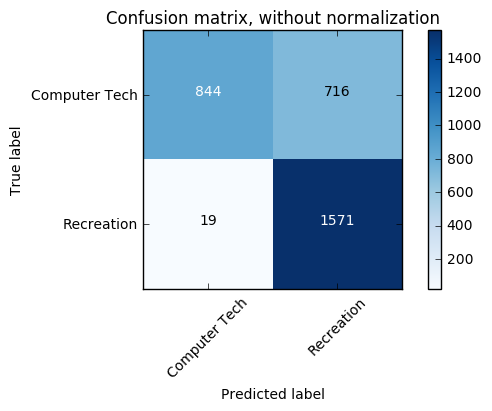

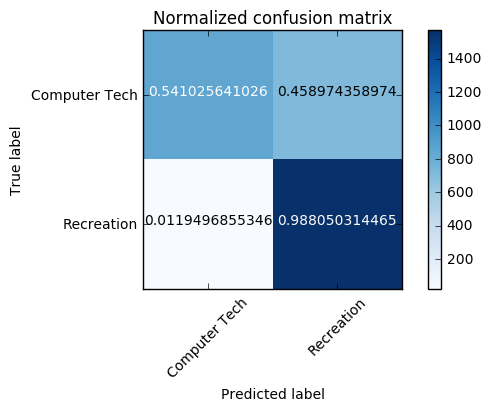

In [375]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### homogeneity score

In [376]:
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

In [377]:
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(test_target_group, kmeans_predict)  

0.30711733196948748

### completeness score

In [378]:
# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [379]:
from sklearn.metrics.cluster import completeness_score
completeness_score(test_target_group, kmeans_predict)

0.36252713800633013

### adjusted rand index

In [380]:
# The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [381]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(test_target_group, kmeans_predict)

0.284250349488987

### adjusted mutual information score

In [382]:
# Adjusted mutual information score measures mutual information between the cluster label distribution and the groud truth label distributions

In [383]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(test_target_group, kmeans_predict)

0.33367404362796677

## Problem 3)

In [30]:
# LSI, Truncated SVD

In [812]:
from sklearn.decomposition import TruncatedSVD
n_components = 500
svd = TruncatedSVD(n_components=n_components, algorithm='arpack')
train_LSI = svd.fit_transform(TFxIDF_train)
test_LSI  = svd.transform(TFxIDF_test)

In [813]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(train_LSI)

In [814]:
kmeans_predict = kmeans.predict(test_LSI)
kmeans_predict[0:20]

array([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1])

In [815]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1
sum(abs(kmeans_predict-test_target_group))

690

Confusion matrix, without normalization
[[ 890  670]
 [  20 1570]]
Normalized confusion matrix
[[ 0.57  0.43]
 [ 0.01  0.99]]


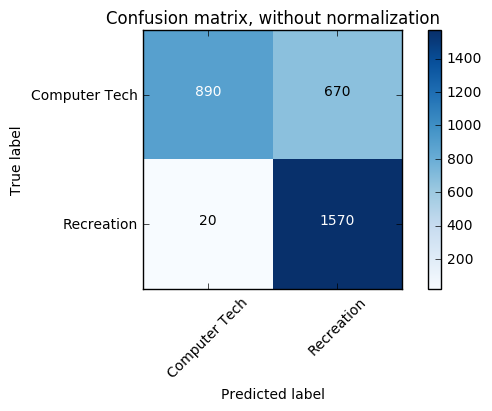

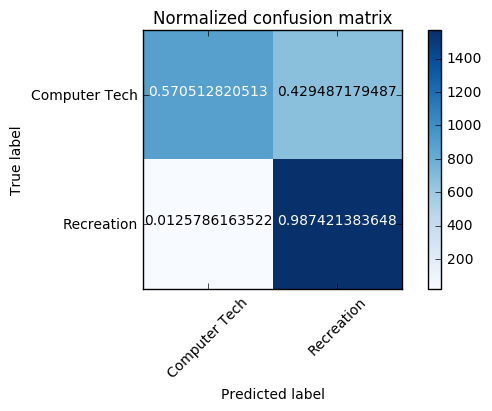

In [816]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### homogeneity score

In [571]:
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(test_target_group, kmeans_predict)  

0.23209992878843411

### completeness score

In [572]:
# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
from sklearn.metrics.cluster import completeness_score
completeness_score(test_target_group, kmeans_predict)

0.30056750197649695

### adjusted rand index

In [573]:
# The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(test_target_group, kmeans_predict)

0.19116952747894192

### adjusted mutual information score

In [574]:
# Adjusted mutual information score measures mutual information between the cluster label distribution and the groud truth label distributions
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(test_target_group, kmeans_predict)

0.26412439456601217

### NMF, Non-Negative Matrix Factorization

In [891]:
from sklearn.decomposition import NMF
n_components = 610
nmf = NMF(n_components=n_components, init = 'nndsvd', random_state=0, alpha=.1, l1_ratio=0).fit(TFxIDF_train)
train_NMF = nmf.fit_transform(TFxIDF_train)
test_NMF  = nmf.transform(TFxIDF_test)

In [892]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter = 1000, random_state=42).fit(train_NMF)
kmeans_predict = kmeans.predict(test_NMF)

In [893]:
if sum(abs(kmeans_predict-test_target_group))>len(kmeans_predict)/2:
    i = 0
    for candidate in kmeans_predict:
        
        if candidate == 1:
            kmeans_predict[i] = 0
        elif candidate == 0:
            kmeans_predict[i] = 1
        i = i+1
sum(abs(kmeans_predict-test_target_group))

440

Confusion matrix, without normalization
[[1138  422]
 [  18 1572]]
Normalized confusion matrix
[[ 0.73  0.27]
 [ 0.01  0.99]]


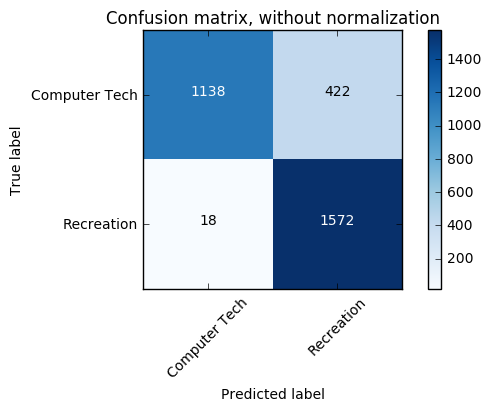

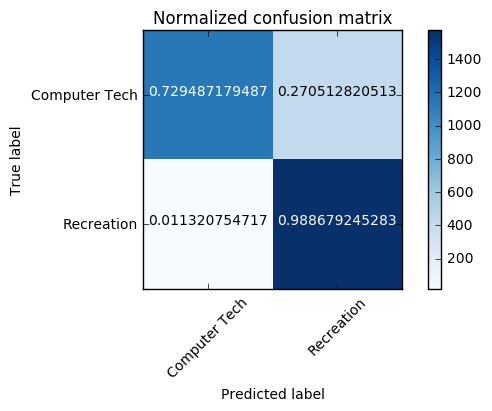

In [894]:
from sklearn.metrics import confusion_matrix
import itertools
class_names = ['Computer Tech', 'Recreation']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_target_group, kmeans_predict)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### homogeneity score

In [895]:
# A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
from sklearn.metrics.cluster import homogeneity_score
homogeneity_score(test_target_group, kmeans_predict) 

0.48613142177905266

### completeness score

In [896]:
# A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
from sklearn.metrics.cluster import completeness_score
completeness_score(test_target_group, kmeans_predict)

0.51258582267988761

### adjusted rand index

In [897]:
# The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(test_target_group, kmeans_predict)

0.5191697286302122

### adjusted mutual information score

In [898]:
# Adjusted mutual information score measures mutual information between the cluster label distribution and the groud truth label distributions
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(test_target_group, kmeans_predict)

0.49918340794056765

In [899]:
print kmeans_predict.shape
print train_NMF.shape
print test_NMF.shape

(3150L,)
(4732L, 610L)
(3150L, 610L)


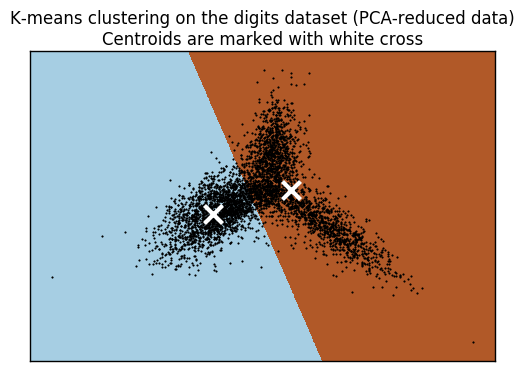

In [900]:
from sklearn.preprocessing import scale
data = scale(train_NMF)

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()